In [1]:
# import necessary libraries
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import cv2

In [2]:
# import datasets 
train_labels = np.array(pd.read_csv("../datasets/train_labels.csv", delimiter=",", header=0, index_col=0))
train_images = np.load("../datasets/train_images.npy", encoding="latin1")
test_images = np.load("../datasets/test_images.npy", encoding="latin1")

In [3]:
def reshape(dataset):
    '''Reshape images from dimension 10000 --> 100*100
    :param dataset: 
    '''
    output = []
    for img in dataset:
        output.append(img.reshape(100,100))
    return np.array(output, dtype=int)

In [4]:
def unravel(dataset):
    '''Reshape images from dimension 100*100 --> 10000
    :param dataset: 
    '''
    output = []
    for img in dataset:
        output.append(img.ravel())
    return np.array(output, dtype=int)

In [5]:
def prepareToSaveNPY(dataset):
    '''Convert numpy array to format previously saved in .npy
    :param dataset: 
    '''
    output = []
    for i in range(len(dataset)):
        output.append((int(i), np.array(dataset[i], dtype=float)))
    return np.array(output, dtype=object)

In [6]:
def binarize(dataset, threshold):
    '''Convert greyscale to binary according to threshold
    :param dataset:
    :param threshold:
    '''
    output = []
    for img in dataset:
        img[img < threshold] = 0
        img[img >= threshold] = 255
        output.append(img)
    return np.array(output, dtype=int)

In [7]:
def denoise(dataset, connectivity):
    '''Remove noise surrounding connected component i.e. supposed doodle
    :param dataset:
    :param connectivity:
    '''
    output = []
    for img in dataset:
        img_binary = (img > 0).astype(np.uint8)
        nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(img_binary, connectivity, cv2.CV_32S)
        areas = stats[:,-1]
        max_label = 1
        max_area = areas[1]
        for j in range(1, nb_components):
            if areas[j] > max_area:
                max_label = j
                max_area = areas[j]
        labels[labels != max_label] = 0
        output.append(labels)
    return np.array(output, dtype=int)

In [8]:
def square(img, dim):
        '''Crop image to a square
        :param img: image to be cropped
        :param dim: height and width of square image
        '''
        height, width = img.shape
        if height > width:
            differ = height
        else:
            differ = width
        differ += 4
        mask = np.zeros((differ, differ), dtype="uint8")   
        x_pos = int((differ-width)/2)
        y_pos = int((differ-height)/2)
        mask[y_pos:y_pos+height, x_pos:x_pos+width] = img[0:height, 0:width]
        mask = cv2.resize(mask, (dim,dim), interpolation=cv2.INTER_AREA)
        return mask
    
def crop(dataset):
    '''Crop images to contain supposed doodle
    :param dataset:
    '''
    output = []
    for img in dataset:
        row_mask = np.all(np.isnan(img) | np.equal(img, 0), axis=1)
        col_clean = np.transpose(img[~row_mask])
        col_mask = np.all(np.isnan(col_clean) | np.equal(col_clean, 0), axis=1)
        new_img = np.transpose(col_clean[~col_mask])
        new_img = square(new_img, 100)
        output.append(new_img)
    return np.array(output, dtype=int)   

In [9]:
def results(original, denoised, cropped, labels, num):
    '''Check preprocessing results
    :param num: number of randomly selected images to compare preprocessing results
    '''
    plot = np.random.randint(0,10000,num) # some randompy picked images
    #plot = np.array([,,,,,,,,,,,1407]) # some handpicked problematic images
    fig = plt.figure(figsize = (12,3*num))
    for i in range(len(plot)):
        img1 = original[plot[i]]
        img2 = denoised[plot[i]]
        img3 = cropped[plot[i]]
        label = np.array([str(plot[i]), labels[plot[i]][0]])
        # plot original image
        subplot = fig.add_subplot(num, 3, 3*i+1, title=label)
        subplot.imshow(img1, cmap='gray_r')
        subplot.axes.get_xaxis().set_visible(False)
        subplot.axes.get_yaxis().set_visible(False)
        # plot denoised image
        subplot = fig.add_subplot(num, 3, 3*i+2, title=label)
        subplot.imshow(img2, cmap='gray_r')
        subplot.axes.get_xaxis().set_visible(False)
        subplot.axes.get_yaxis().set_visible(False)
        # plot cropped image
        subplot = fig.add_subplot(num, 3, 3*i+3, title=label)
        subplot.imshow(img3, cmap='gray_r')
        subplot.axes.get_xaxis().set_visible(False)
        subplot.axes.get_yaxis().set_visible(False)
    plt.show()

In [10]:
# preprocess datasets of images
train_x0 = reshape(train_images[:,1])
train_x1 = binarize(train_x0, 100)
train_x2 = denoise(train_x1, 8)
train_x = crop(train_x2)
test_x0 = reshape(test_images[:,1])
test_x1 = binarize(test_x0, 100)
test_x2 = denoise(test_x1, 8)
test_x = crop(test_x2)

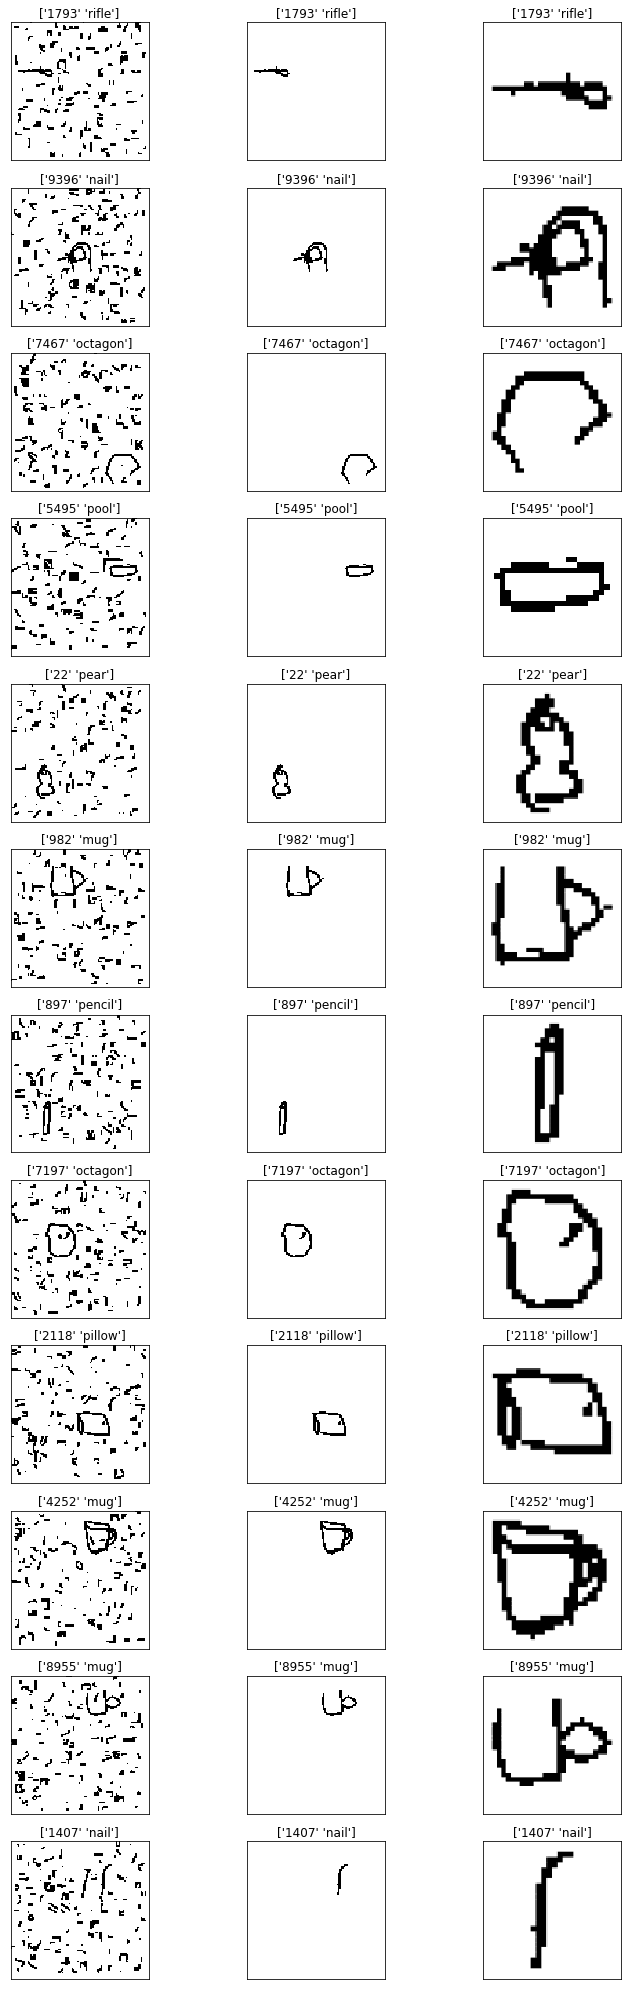

In [11]:
# check preprocessing results
results(train_x0, train_x2, train_x, train_labels, 12)

In [13]:
# save preprocessed images
np.save("../datasets/train_images_cropped.npy", prepareToSaveNPY(unravel(train_x)))
np.save("../datasets/test_images_cropped.npy", prepareToSaveNPY(unravel(test_x)))